In [1]:
import pennylane as qml
import matplotlib as mpl
import matplotlib.pyplot as plt
from pennylane import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_vector, array_to_latex, plot_bloch_multivector
n_wires = 4
dev = qml.device("default.qubit", wires=4)

# Making the unitary

If we have $U = \begin{pmatrix}a&b\\c&d\end{pmatrix}$ as a unitary matrix, then we need that:

$$\begin{align*}
    a &= e^{i\alpha}e^{x}\cos z\\
    b &= e^{i\alpha}e^{y}\sin z\\
    c &= -e^{i\alpha}e^{-y}\sin z\\
    d &= e^{i\alpha}e^{-x}\cos z
\end{align*}$$

where $\alpha, x, y, z$ are arbitrary reals. <br>

To avoid a global phase in making our arbitrary $U$, we choose $\alpha = 0$ and the other angles as:

In [2]:
x = -0.56
y = 1.8
z = 0.3
U = np.array([[np.exp(1.j*x)*np.cos(z), -np.exp(1.j*y)*np.sin(z)], 
              [np.exp(-1.j*y)*np.sin(z), np.exp(-1.j*x)*np.cos(z)]])
print(f"Our arbitraty unitary is: U = \n{U}")

Our arbitraty unitary is: U = 
[[ 0.80941372-0.50746156j  0.06714281-0.28779165j]
 [-0.06714281-0.28779165j  0.80941372+0.50746156j]]


# Decompositional Ansatz
We know that every unitary operation can be written as:
$$U = e^{i\alpha}R_z(\gamma)R_y(\beta)R_z(\delta)$$
We aim to learn the values of $\gamma, \beta, \delta$ variationally.<br>
Let:
$U' = R_z(\gamma)R_y(\beta)R_z(\delta)$
To do so, we need to match the action of the chosen $U$ and our $U'$ on every 1-qubit state $\psi$, upto a global phase.<br>
The metric we choose for this is: $|\langle U\psi|U'\psi\rangle| = \langle \psi^{\dagger}U^{\dagger}|U'\psi\rangle$.<br>

# Qubits needed

Since every unitary operation upto a global phase is a rotation on the Bloch sphere, we need to know where 2 non-diametrically opposite points end up to completely determine the rotation.<br>
Hence, we will need atleast 4 qubits for our QML circuit.<br>
In the following we initialize them as:
$q_1 = q_2 = |0\rangle, q_3 = q_4 = |+\rangle$.<br>
Then we apply the chosen $U$ on $q_2, q_4$ and the current $U'$ on $q_1, q_3$. <br>
(Using the method learnt in QC_eval1)<br>
With the probabilities of the measurement of the state $|q_1 q_2\rangle$ we estimate $|\langle 0|U^{\dagger}U'|0\rangle|^2$.<br>
With the probabilities of the measurement of the state $|q_3 q_4\rangle$ we estimate $|\langle +|U^{\dagger}U'|+\rangle|^2$.<br>
Our loss function is: $2 - |\langle 0|U^{\dagger}U'|0\rangle|^2 - |\langle +|U^{\dagger}U'|+\rangle|^2 \geq 0$, which will hit its minimum of 0 when $U = U'$ upto a global phase.<br>

The PennyLane optimizer varies the current values of $[\delta, \gamma, \beta]$ along the gradient in order to minimize our loss function. 

In [3]:
def ansatz(params):
    #the decomposition
    qml.RZ(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    #the actual unitary gate
    qml.QubitUnitary(U, wires=1)
    #the inner product evaluator
    qml.CNOT(wires=[0, 1])
    qml.Hadamard(wires=0)
    
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)
    #the decomposition
    qml.RZ(params[0], wires=2)
    qml.RY(params[1], wires=2)
    qml.RZ(params[2], wires=2)
    #the actual unitary gate
    qml.QubitUnitary(U, wires=3)
    #the inner product evaluator
    qml.CNOT(wires=[2, 3])
    qml.Hadamard(wires=2)

@qml.qnode(dev)
def cost_1(params):
    ansatz(params)
    return qml.probs(wires=[0, 1])

@qml.qnode(dev)
def cost_2(params):
    ansatz(params)
    return qml.probs(wires=[2, 3])


def cost(params):
    X = cost_1(params)
    Y = cost_2(params)
    return (X[0] + X[1] + X[2] - X[3] + Y[0] + Y[1] + Y[2] - Y[3])

[0.36857703 0.21169298 0.16061393 0.25911606] [0.15080548 0.36396744 0.14930698 0.33592009]


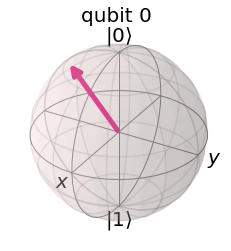

In [4]:
init_params = np.array([0, 1.5, 0.5], requires_grad=True)
#[delta, gamma, beta]; U = Rz(beta)Ry(gamma)Rz(delta)
print(cost_1(init_params), cost_2(init_params))
state = U[:, 0].tolist()
plot_bloch_multivector(state)

# The Gradient Descent
As can be seen in the bloch vectors plotted (at steps of 20), the vector $U'|0\rangle$, which is the first column of our predicted unitary, approaches the above shown $U|0\rangle$.<br>

The modified function, $2-$the loss, also quickly approaches 2.

-----------Step No. 1-----------
The current values of [delta, gamma, beta]: [0.  1.5 0.5]
The current sum of the inner products: 0.8099276965617155
-----------Step No. 41-----------
The current values of [delta, gamma, beta]: [ 0.29702344 -0.34950518  0.79785579]
The current sum of the inner products: 1.9280134350326312
-----------Step No. 81-----------
The current values of [delta, gamma, beta]: [-0.20397319 -0.46720418  1.32804194]
The current sum of the inner products: 1.973575545033713
-----------Step No. 121-----------
The current values of [delta, gamma, beta]: [-0.55195012 -0.54773426  1.67955567]
The current sum of the inner products: 1.99496835665339
-----------Step No. 161-----------
The current values of [delta, gamma, beta]: [-0.71080761 -0.58464103  1.83423658]
The current sum of the inner products: 1.999481491759433


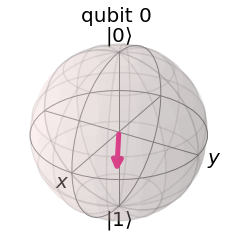

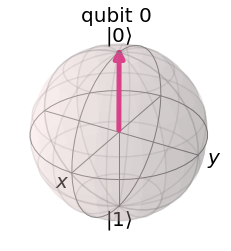

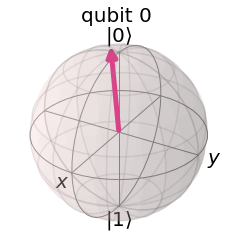

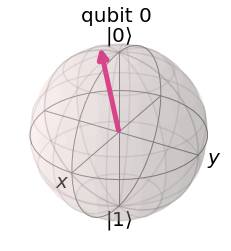

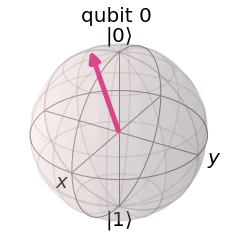

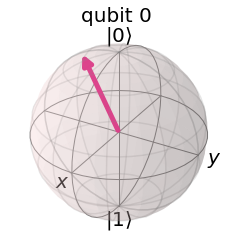

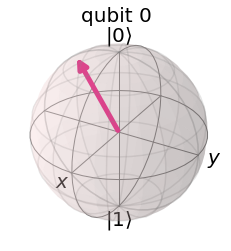

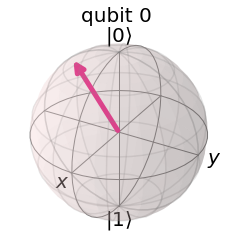

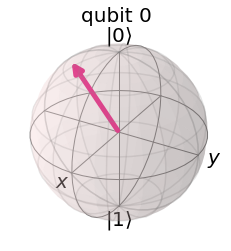

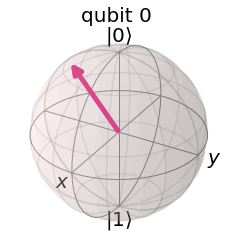

In [5]:
#stepsize negative to maximize the inner product sum
opt = qml.GradientDescentOptimizer(stepsize=-0.3)
steps = 200
params = init_params
for i in range(steps):
    if(i < 200 and i % 20 == 0):
        M1 = qml.matrix(qml.RZ(params[0], wires=0))
        M2 = qml.matrix(qml.RY(params[1], wires=0))
        M3 = qml.matrix(qml.RZ(params[2], wires=0))
        M = np.matmul(M3, np.matmul(M2, M1))
        state = M[:, 0].tolist()
        plt.figure(plot_bloch_multivector(state))
    if(i % 40 == 0):
        print(f"-----------Step No. {i+1}-----------")
        print(f"The current values of [delta, gamma, beta]: {params}")
        print(f"The current sum of the inner products: {cost(params)}")
    if(abs(cost(params) - 2) < 0.0000001):
        break
        print(f"-----------Step No. {i+1}-----------")
        print(f"The current values of [delta, gamma, beta]: {params}")
        print(f"The current sum of the inner products: {cost(params)}")
    params = opt.step(cost, params)

# The matrices

We can use our final parameters to get the predicted unitary by matrix multiplication as follows

In [6]:
M1 = qml.matrix(qml.RZ(params[0], wires=0))
M2 = qml.matrix(qml.RY(params[1], wires=0))
M3 = qml.matrix(qml.RZ(params[2], wires=0))
M = np.matmul(M3, np.matmul(M2, M1))
print(f"The predicted unitary U' is: \n{M}")
print(f"The actual unitary U is: \n{U}")

The predicted unitary U' is: 
[[ 0.80965583-0.50820479j  0.07206887-0.28458989j]
 [-0.07206887-0.28458989j  0.80965583+0.50820479j]]
The actual unitary U is: 
[[ 0.80941372-0.50746156j  0.06714281-0.28779165j]
 [-0.06714281-0.28779165j  0.80941372+0.50746156j]]


# Distance between the two

We can compute how different the 2 are using:
$$d = \sqrt{\sum_{i = 1}^2\sum_{j=1}^2|u'_{ij}-u_{ij}|^2}$$
And as can be seen below, the obtained unitary is very close to the given one.

In [7]:
d = 0
for i in range(2):
    for j in range(2):
        print(np.abs(M[i][j]-U[i][j]))
        d += (np.abs(M[i][j]-U[i][j]))**2
print(d)

0.0007816724357066087
0.005875152508905844
0.005875152508905844
0.0007816724357066087
7.025685759929228e-05
